In [1]:
!nvidia-smi

Tue Nov  7 12:47:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Environment setup

In [3]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 

In [4]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
roboflow: 1.1.9 ; supervision: 0.3.0 ; transformers: 4.35.0 ; pytorch_lightning: 2.1.0


## Inference with pre-trained COCO model

### Download Data

In [5]:
%cd {HOME}
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

/content
--2023-11-07 12:48:25--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2023-11-07 12:48:25 (123 MB/s) - ‘dog.jpeg’ saved [106055/106055]



In [6]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

### Load Model

In [7]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

### Inference

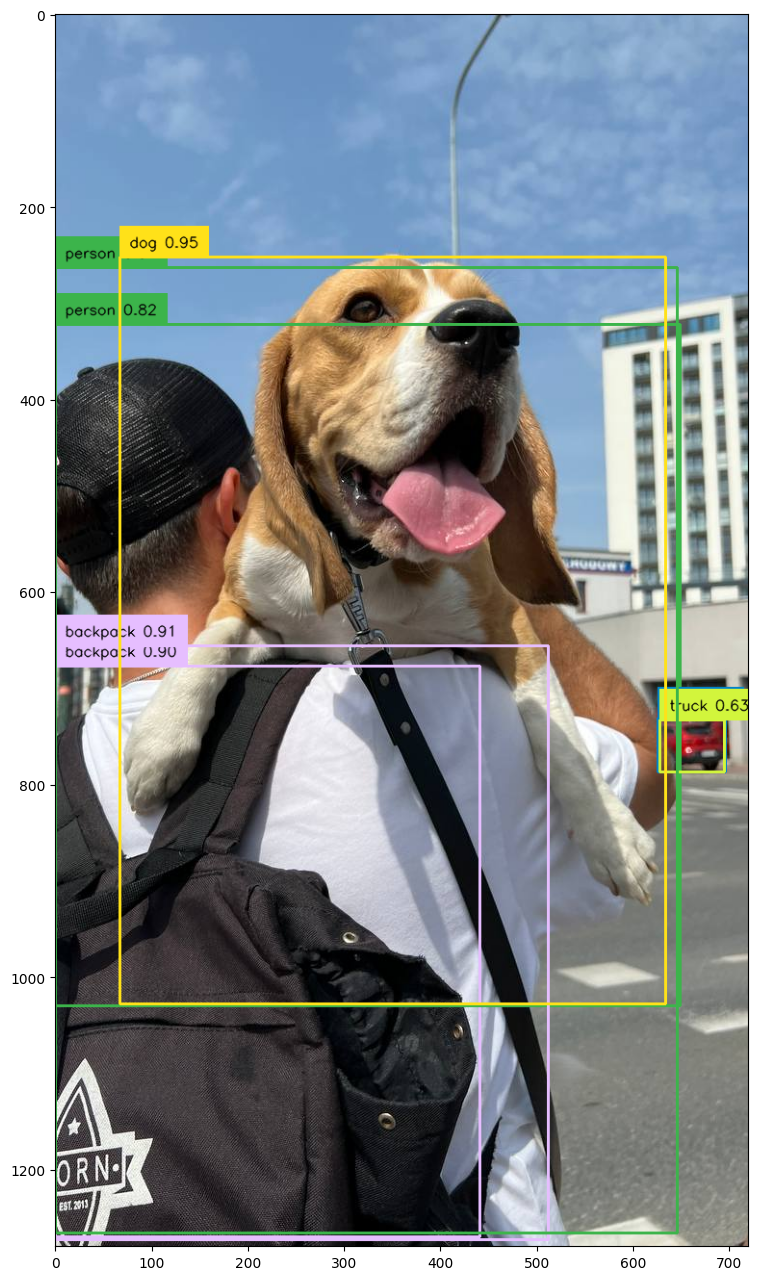

In [8]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread(IMAGE_PATH)
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

**NOTE:** It seems that we have a lot of excess detections. Let's try to filter them out using non-max suppression.

## Inference + NMS

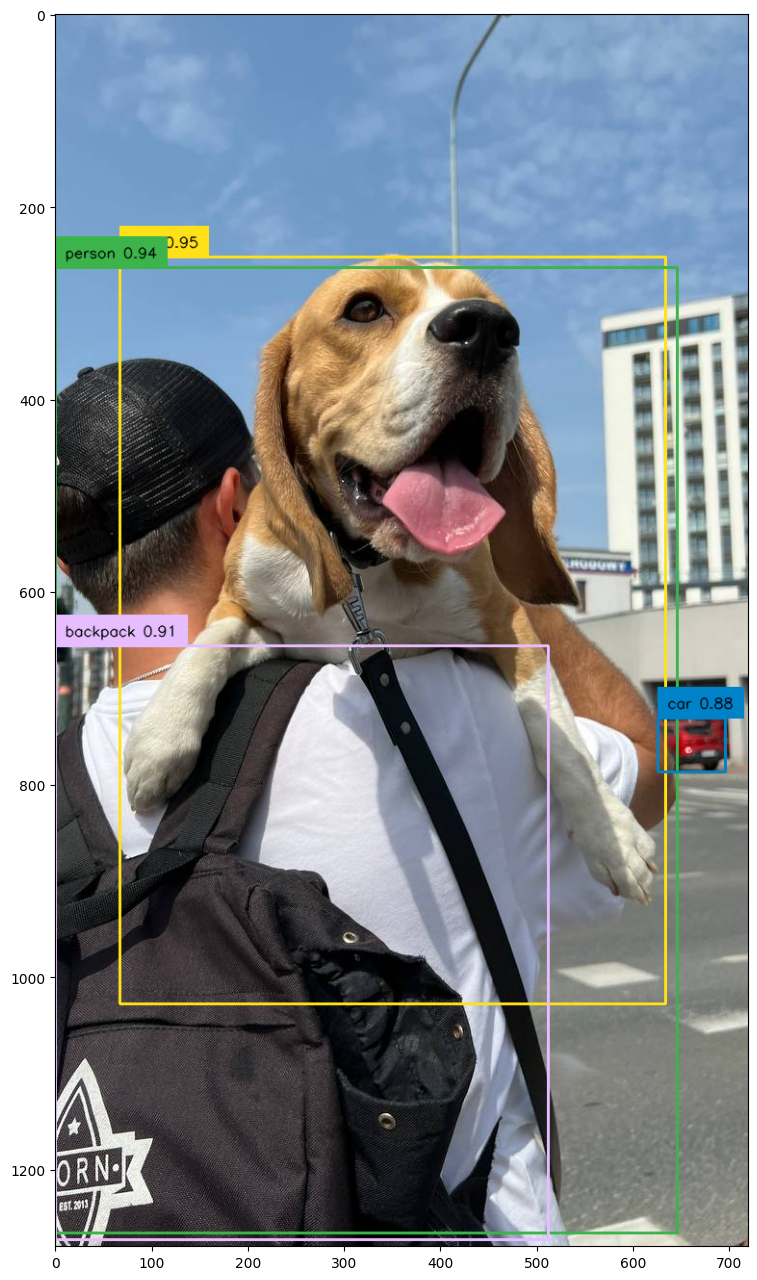

In [9]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread(IMAGE_PATH)
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [10]:
from getpass import getpass

ROBOFLOW_API_KEY = getpass('Enter ROBOFLOW_API_KEY secret value: ')

Enter ROBOFLOW_API_KEY secret value: ··········


In [11]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(1).download("coco")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-1 in coco:: 100%|██████████| 671/671 [00:00<00:00, 1161.55it/s]


**NOTE:** We can find out where our dataset was saved using the `dataset.location` property.

In [12]:
dataset.location

'/content/datasets/football-players-detection-1'

## Create COCO data loaders

In [13]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 612
Number of validation examples: 38
Number of test examples: 13


## Visualize data entry

**NOTE:** Feel free to reload this cell multiple times. Notebook should display different train set image each time.

Image #560


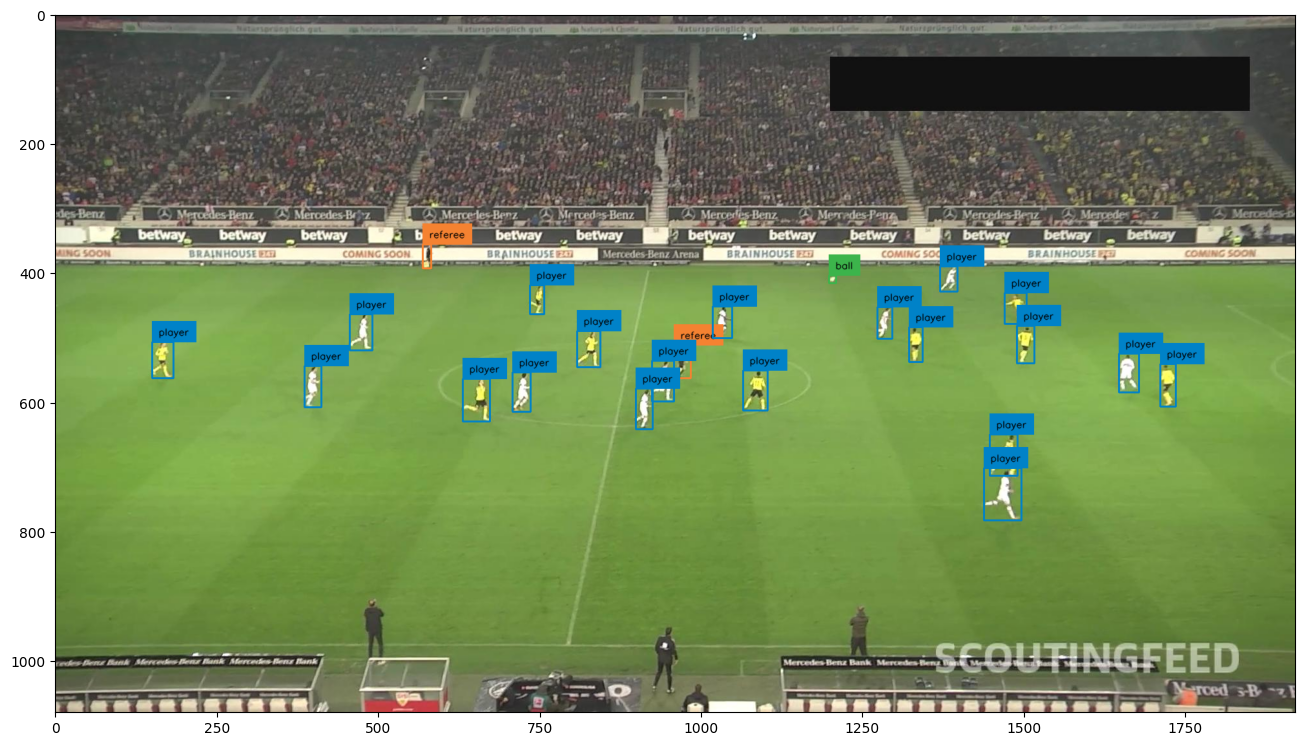

In [14]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [15]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model with PyTorch Lightning

**NOTE:** Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [16]:
# import pytorch_lightning as pl
# from transformers import DetrForObjectDetection
# import torch


# class Detr(pl.LightningModule):

#     def __init__(self, lr, lr_backbone, weight_decay):
#         super().__init__()
#         self.model = DetrForObjectDetection.from_pretrained(
#             pretrained_model_name_or_path=CHECKPOINT,
#             num_labels=len(id2label),
#             ignore_mismatched_sizes=True
#         )

#         self.lr = lr
#         self.lr_backbone = lr_backbone
#         self.weight_decay = weight_decay

#     def forward(self, pixel_values, pixel_mask):
#         return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

#     def common_step(self, batch, batch_idx):
#         pixel_values = batch["pixel_values"]
#         pixel_mask = batch["pixel_mask"]
#         labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

#         outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

#         loss = outputs.loss
#         loss_dict = outputs.loss_dict

#         return loss, loss_dict

#     def training_step(self, batch, batch_idx):
#         loss, loss_dict = self.common_step(batch, batch_idx)
#         # logs metrics for each training_step, and the average across the epoch
#         self.log("training_loss", loss)
#         for k,v in loss_dict.items():
#             self.log("train_" + k, v.item())

#         return loss

#     def validation_step(self, batch, batch_idx):
#         loss, loss_dict = self.common_step(batch, batch_idx)
#         self.log("validation/loss", loss)
#         for k, v in loss_dict.items():
#             self.log("validation_" + k, v.item())

#         return loss

#     def configure_optimizers(self):
#         # DETR authors decided to use different learning rate for backbone
#         # you can learn more about it here:
#         # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
#         # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
#         param_dicts = [
#             {
#                 "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
#             {
#                 "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
#                 "lr": self.lr_backbone,
#             },
#         ]
#         return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

#     def train_dataloader(self):
#         return TRAIN_DATALOADER

#     def val_dataloader(self):
#         return VAL_DATALOADER

In [17]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

        if torch.cuda.device_count() > 1:
            self.model = DataParallel(self.model)

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

    def parallel_decode(self, memory, query):
        # Use the parallel decoder to decode in parallel
        return self.parallel_decoder(memory, query)

**NOTE:** Let's start `tensorboard`.

In [18]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [19]:
outputs.logits.shape

torch.Size([4, 100, 6])

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
%cd {HOME}

# settings
MAX_EPOCHS = 20


# early_stop_callback = EarlyStopping(
#     monitor='validation/loss',  # monitor the validation loss
#     min_delta=0.00,  # minimum change in the monitored quantity to qualify as improvement
#     patience=3,  # number of epochs with no improvement after which training will be stopped
#     verbose=False,  # don't print the early stopping messages
#     mode='min'  # the monitored quantity should be minimized
# )



# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5 )

trainer.fit(model)
torch.save(model.state_dict(), 'model.pt')

/content


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Inference on test dataset

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
model.to(DEVICE)

In [ ]:
import random
import cv2
import numpy as np
from PIL import Image

# Load image
image_path = '/content/football.jpg'
image = Image.open(image_path)

# Convert to numpy array
image_np = np.array(image)

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
# image_ids = TEST_DATASET.coco.getImgIds()
# image_id = random.choice(image_ids)
# print('Image #{}'.format(image_id))

# # load image and annotatons
# image = TEST_DATASET.coco.loadImgs(image_id)[0]

annotations = TEST_DATASET.coco.imgToAnns[image_id]
# image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
# detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
# labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
# frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# print('ground truth')
# %matplotlib inline
# sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## Evaluation on test dataset

Finally, we evaluate the model on the `TEST_DATASET`. For this we make use of the `CocoEvaluator` class available in a tiny [PyPi package](https://github.com/NielsRogge/coco-eval) made by [Niels Rogge](https://github.com/NielsRogge) . This class is entirely based on the [original evaluator](https://github.com/facebookresearch/detr/blob/main/datasets/coco_eval.py) class used by the DETR authors.

In [ ]:
!pip install -q coco_eval

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

## Save and load model

In [ ]:
MODEL_PATH = os.path.join(HOME, 'custom-model')

In [ ]:
model.model.save_pretrained(MODEL_PATH)

In [ ]:
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)